In [1]:
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype 
import matplotlib.ticker as ticker
import math

In [2]:
df = pd.read_csv("Output/Combined_dataset.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)

# Drop duplicates
df = df.drop_duplicates('id', keep ='first')
print(df.shape)

(1000, 32)
(985, 32)


In [3]:
# Convert numeric cols to int/floats
df['duration'] = pd.to_numeric(pd.to_timedelta(df['duration']).dt.days, downcast='integer')
df['num_faq'] = df['num_faq'].astype(int)
df['n_comments'] = df['n_comments'].str.replace(',', '').astype(float)

# Convert rows from str to dict
def string_to_dict(dict_string):
    # Convert to proper json format
    dict_string = dict_string.replace("'", "'").replace('u"', '"')
    return json.loads(dict_string)

df.category = df.category.apply(string_to_dict)

# Get Location of Projects from location dict
def get_location(i):
    i = str(i).replace('nan', '{"name": ""}')
    i = i.replace('false', 'False')
    i = i.replace('null', '{"name": ""}')
    name_i = eval(i).get('name')
    if len(name_i) == 0:
        return None
    else:
        if name_i.isdigit():
            return None
        else:
            return name_i
    
df['location_name'] = df.location.apply(lambda x: get_location(x))

# Get category values from dictionary
df['parent_category'] = [d.get('parent_name') for d in df.category]
df['category_name'] = [d.get('name') for d in df.category]
df["parent_category"].fillna("No Parent Category", inplace = True)

# Fill na for text cols
df["story"].fillna(" ", inplace = True)

df.state = df.state.astype('category').cat.codes

df.sample(1)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,goal,...,usd_type,story,faq,num_faq,comments,n_comments,duration,location_name,parent_category,category_name
627,105,Black Lung Brewing brews intriguing beers with...,"{'id': 307, 'name': 'Drinks', 'slug': 'food/dr...",17036,US,2020-10-25 20:22,USD,2020-12-21 7:29,1.0,15000,...,international,"On the east edge of Round Lake Beach, the old ...",[' '],0,Only backers can post comments. Log in\r\nDani...,3.0,45,Round Lake Beach,Food,Drinks


In [4]:
categorical_cols = ['country', 'staff_pick', 'usd_type', 'parent_category', 'category_name']
num_cols = ['backers_count', 'fx_rate', 'goal', 'pledged', 'num_faq', 'n_comments', 'duration']
text_cols = ['blurb', 'name', 'story', 'faq', 'comments']

## Categorical

In [5]:
#Cat DF
for i in df[categorical_cols]:
    print(df[i].value_counts())
    print(" ")
    
#US and GB has the most number of project
#Top 5 most popular cat: Art, Film & video, Tech, music, photography
#Top 5 most popular sub-cat: painting, illustration, world music, web and apparel

US    645
GB    117
CA     43
AU     29
DE     22
MX     20
FR     19
ES     18
NL     11
IT     10
SE      9
SG      8
HK      6
DK      5
NZ      5
JP      4
CH      4
AT      3
NO      2
BE      2
IE      2
LU      1
Name: country, dtype: int64
 
False    849
True     136
Name: staff_pick, dtype: int64
 
domestic         735
international    250
Name: usd_type, dtype: int64
 
Art                   192
Film & Video          144
Music                  83
Technology             83
Photography            71
Games                  66
Publishing             63
Fashion                60
No Parent Category     58
Journalism             44
Comics                 37
Food                   33
Theater                30
Dance                  18
Crafts                  3
Name: parent_category, dtype: int64
 
Painting            56
Illustration        56
World Music         53
Web                 50
Apparel             48
                    ..
Romance              1
Residencies          1
Camera

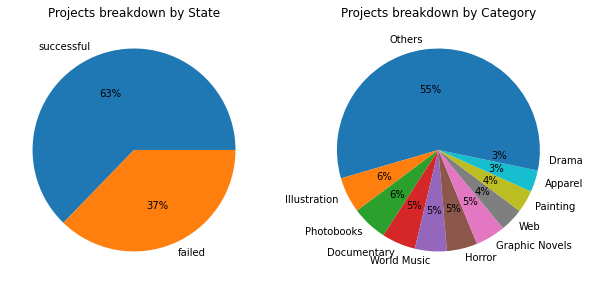

In [6]:
# Breakdown of project 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10)) 

# 1. by state
ax1.pie(df['state'].value_counts(), labels = ['successful', 'failed'], autopct='%1.0f%%')
ax1.set_title('Projects breakdown by State')

# 2. by category
# get top 10 categories by number of projects
top_categories = df.groupby('category_name')['id'].count().reset_index().sort_values('id', ascending = False)[:10].category_name.tolist()
df['top_categories'] = np.where(df.category_name.isin(top_categories), df.category_name, 'Others')

ax2.pie(df['top_categories'].value_counts(), labels= df['top_categories'].unique().tolist(), autopct='%1.0f%%')
ax2.set_title('Projects breakdown by Category')

plt.show()

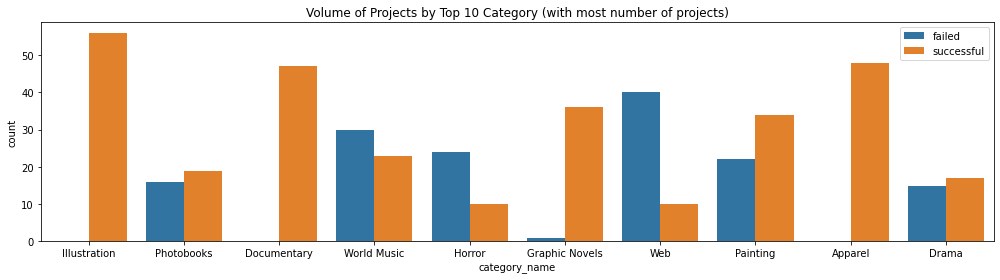

In [7]:
ax = plt.figure(figsize=(14,4))

# Get the number of projects from top 10 most popular categories 
top_categories_df = df[df.category_name.isin(top_categories)]

ax = sns.countplot(x='category_name', hue='state', data= top_categories_df)

ax.set_title('Volume of Projects by Top 10 Category (with most number of projects)')
ax.legend(['failed', 'successful'])

plt.tight_layout()
plt.show()

<b> Category: </b><br>
Categories with highest success rate are Illustration, Documentary, Graphic Novels and Apparls. <br>
Categories with approx 1:1 success:failed ratios are Photobooks, World Music and Drama

## Numeric

C:\Users\Cocoleah\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


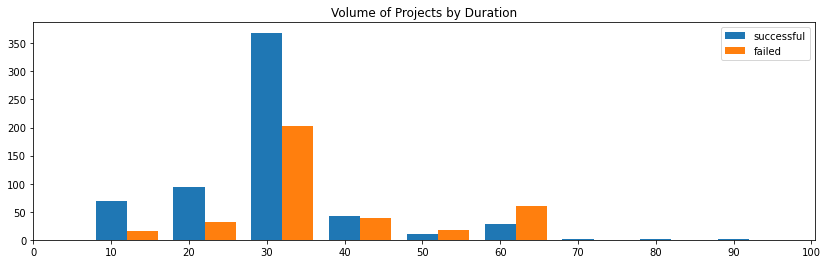

In [8]:
# Get the number of projects by duration
plt.figure(figsize=(14,4))

plt.hist([df[df.state==1].duration, df[df.state==0].duration], bins = range(min(df.duration), max(df.duration) + 10, 10), label= ['successful', 'failed'])

plt.title('Volume of Projects by Duration')
plt.legend(loc= 'best')
plt.xticks(np.arange(0, 110, 10))


plt.show()

<b> Duration: </b><br>
Most projects tend to run for ~30 days. <br>
Success rate of project decreases with longer duration. 

Significant outliers observed in the features below:


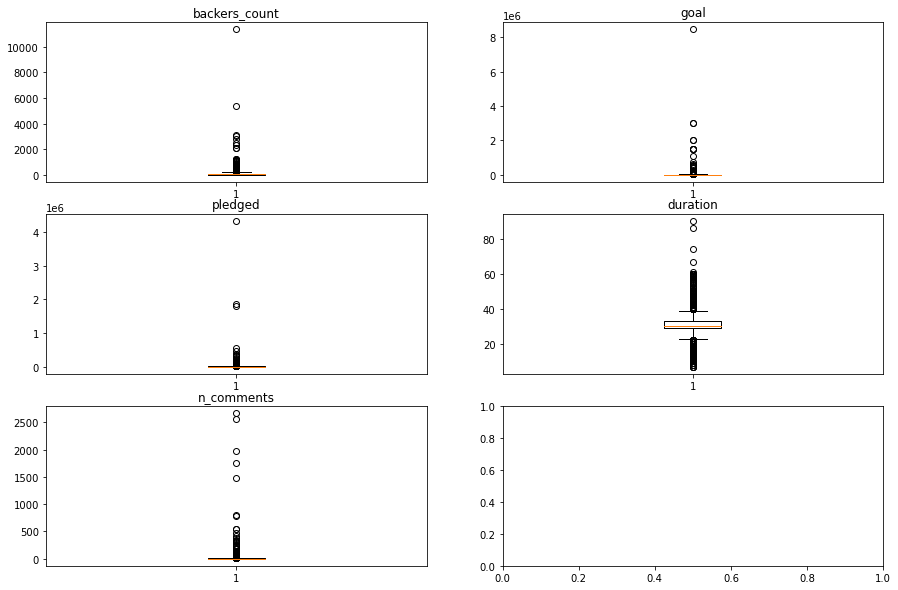

In [9]:
# Outlier Detection
boxplot_features = ['backers_count', 'goal', 'pledged', 'duration', 'n_comments']

max_col = 1 # set number of maximum columns in plot
max_row = 2 # set number of maximum rows in plot
fig, axs = plt.subplots(max_row+1, max_col+1, figsize=(15,10))

row = 0 # initialize first row
col = 0 # initialize first column

for feature in boxplot_features:
    axs[row, col].boxplot(df[feature])
    axs[row, col].set_title(feature)
    if col < max_col:
        col += 1
        continue
    elif col == max_col:
        col = 0 # reset column to 0
        row += 1

print('Significant outliers observed in the features below:')
plt.show()

In [10]:
# Log transformation
for feature in boxplot_features:
    new_col = feature + '_log'
    df[new_col] = df[feature].apply(lambda x: math.log(x+1))
    df[new_col] = (df[new_col] - df[new_col].mean())/df[new_col].std()

# Visualize all features' distributions
print(df.describe()) 

       backers_count  converted_pledged_amount     fx_rate          goal  \
count     985.000000                985.000000  985.000000  9.850000e+02   
mean      121.248731               9843.911675    1.002923  4.347865e+04   
std       477.261685              33288.679016    0.255031  3.331025e+05   
min         0.000000                  0.000000    0.009564  1.000000e+00   
25%         4.000000                170.000000    1.000000  1.000000e+03   
50%        29.000000               1827.000000    1.000000  4.500000e+03   
75%        93.000000               6668.000000    1.000000  1.000000e+04   
max     11340.000000             550868.000000    1.384815  8.450000e+06   

                 id       pledged       state  static_usd_rate    usd_pledged  \
count  9.850000e+02  9.850000e+02  985.000000       985.000000     985.000000   
mean   1.097457e+09  1.989630e+04    0.627411         0.994626    9834.100134   
std    6.240684e+08  1.645487e+05    0.483740         0.256629   33279.9

Distribution after log transformation:


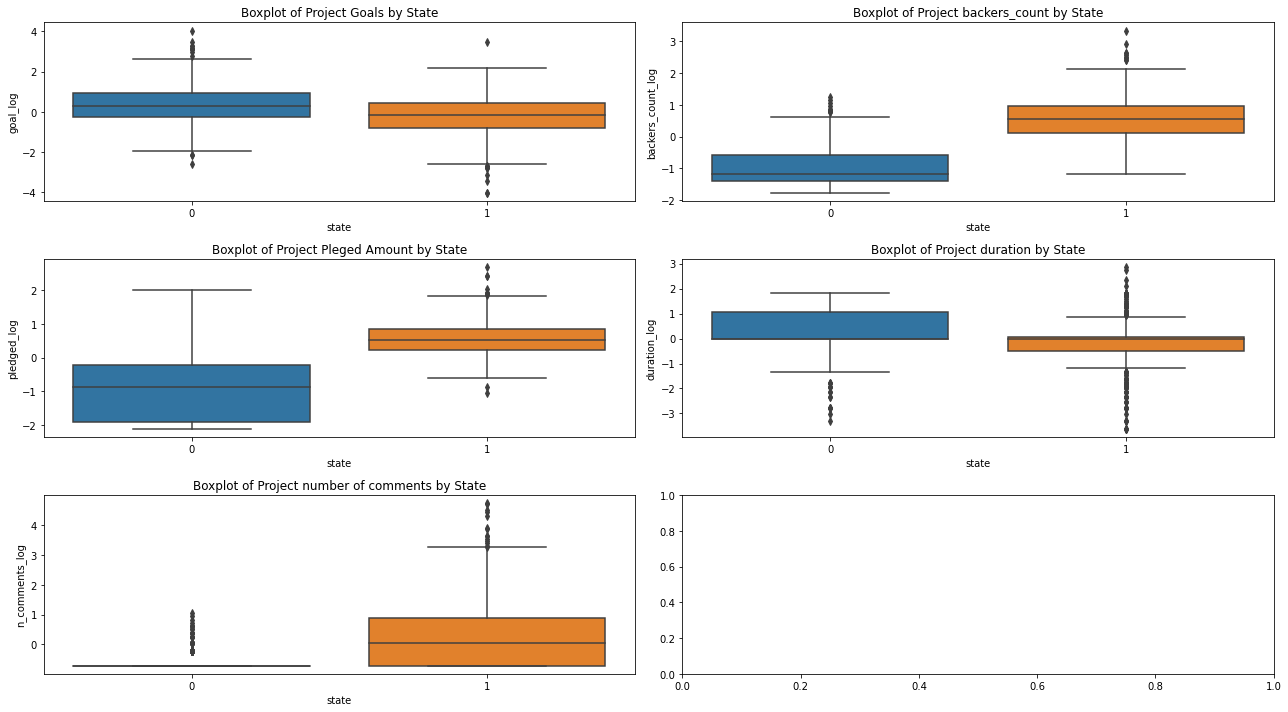

In [11]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(18,10))

# 1. Goals
sns.boxplot(y="goal_log", x="state", data=df, ax= ax1)
ax1.set_title('Boxplot of Project Goals by State')

# 2. Backers Count
sns.boxplot(y="backers_count_log", x="state", data=df, ax= ax2)
ax2.set_title('Boxplot of Project backers_count by State')

# 3. Pledged
sns.boxplot(y="pledged_log", x="state", data=df, ax= ax3)
ax3.set_title('Boxplot of Project Pleged Amount by State')

# 4. Duration
sns.boxplot(y="duration_log", x="state", data=df, ax= ax4)
ax4.set_title('Boxplot of Project duration by State')

# 5. Comments
sns.boxplot(y="n_comments_log", x="state", data=df, ax= ax5)
ax5.set_title('Boxplot of Project number of comments by State')

print('Distribution after log transformation:')
plt.tight_layout()
plt.show()

## Text

In [12]:
# Boolean Transformation
df[['n_comments_bool', 'num_faq_bool']] = df[['n_comments', 'num_faq']].apply(lambda x: np.where(x >0, 1, 0))

In [13]:
#Count no comment proportion
print("no comment:",len(df[df.n_comments_bool==0]))
print("comments:",len(df[df.n_comments_bool==1]))

no comment: 511
comments: 474


In [14]:
#Count no faq proportion
print("no faq:",len(df[df.num_faq_bool==0]))
print("faq:",len(df[df.num_faq_bool==1]))

no faq: 856
faq: 129


~50% of the dataset has no comment, and ~87% of dataset has no faq. <br>
This makes the faq column not meaningful by itself.

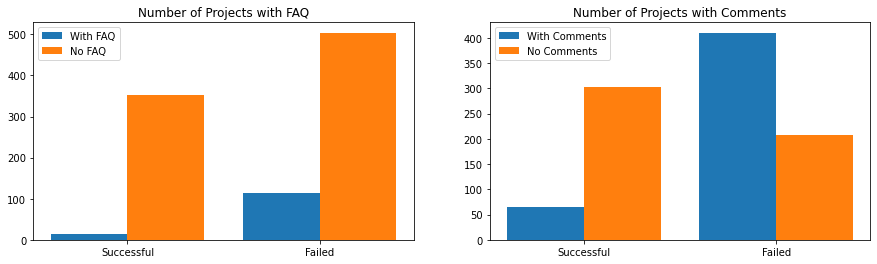

In [15]:
df_faq = df.groupby(["state", 'num_faq_bool'])['id'].count().reset_index().rename(columns={'id':'count_projects'})
df_comments = df.groupby(["state", 'n_comments_bool'])['id'].count().reset_index().rename(columns={'id':'count_projects'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
width = 0.40
  
# 1. FAQ 
ax1.bar(df_faq[df_faq.num_faq_bool==1].state-0.2, df_faq[df_faq.num_faq_bool==1].count_projects, width)
ax1.bar(df_faq[df_faq.num_faq_bool==0].state+0.2, df_faq[df_faq.num_faq_bool==0].count_projects, width)

ax1.set_xticks([0,1])
ax1.set_xticklabels(['Successful', 'Failed'])
ax1.set_title('Number of Projects with FAQ')
ax1.legend(['With FAQ', 'No FAQ'])

# 2. Comments 
ax2.bar(df_comments[df_comments.n_comments_bool==1].state-0.2, df_comments[df_comments.n_comments_bool==1].count_projects, width)
ax2.bar(df_comments[df_comments.n_comments_bool==0].state+0.2, df_comments[df_comments.n_comments_bool==0].count_projects, width)

ax2.set_xticks([0,1])
ax2.set_xticklabels(['Successful', 'Failed'])
ax2.set_title('Number of Projects with Comments')
ax2.legend(['With Comments', 'No Comments'])

plt.show()

Contrary to general expectations that comments could boost a project's performance, it seem that projects with more comments have higher failure than projects with no comments.

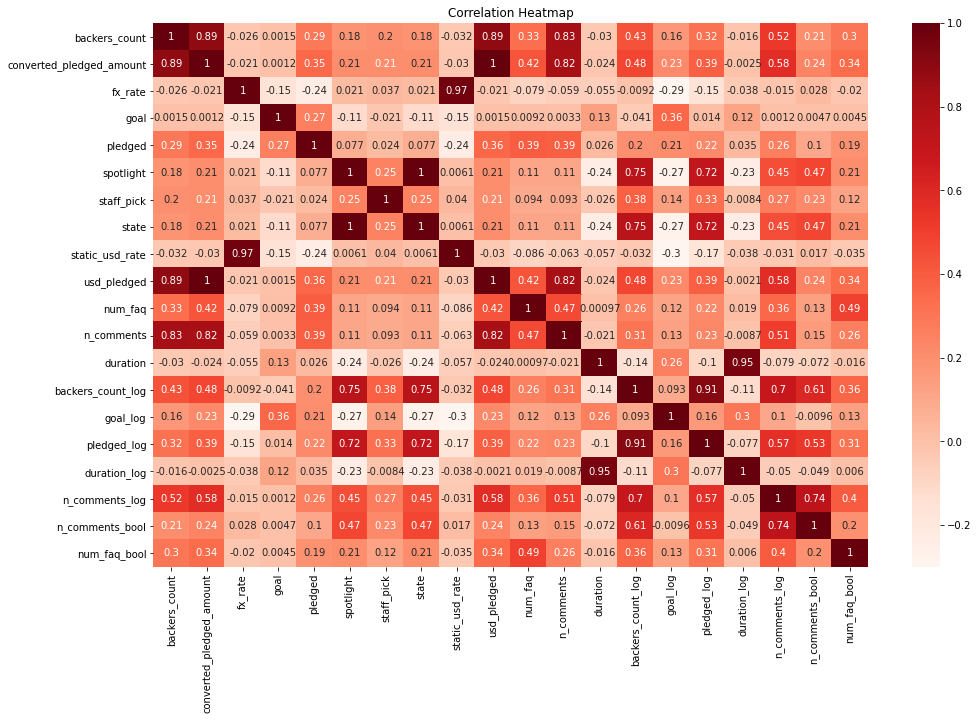

In [16]:
# Correlation heatmap
plt.figure(figsize=(16,10))
cor = df.drop('id', axis=1).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds).set_title("Correlation Heatmap")

plt.show()

Features with high correlation:

1. converted_pledged_amount with usd_pledged,
2. static_usd_rate with fx_rate
3. usd_pledged with backers_count
4. state with spotlight
5. n_comments with converted_pledged_amount
6. n_comments with backers_count
7. converted_pledged_amount with converted_pledged_amount

## Location

In [17]:
#function to get longitude and latitude data from country name
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='anony@gmail.com', timeout=10)

def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        if loc is None:
            return ([np.nan, np.nan])
        else:
        # And return latitude and longitude
            return ([loc.latitude, loc.longitude])
    except:
        # Return missing value
        return ([np.nan, np.nan])

In [18]:
# df['lat_lon'] = df['country'].apply(lambda x: geolocate(x))
# df[['lat','lon']] = pd.DataFrame(df.lat_lon.tolist(), index= df.index)
# df.to_csv('df_with_latlon.csv')

df2 = pd.read_csv("df_with_latlon.csv")
df = pd.merge(df, df2[['id', 'lat_lon']], on = ['id'])
df[['lat','lon']] = pd.DataFrame(df.lat_lon.apply(lambda x: x.strip('[]').split(',')).tolist(), index= df.index)

df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

In [29]:
group_total_country = df.groupby(['country', 'lat', 'lon'])['id'].count().reset_index().sort_values(by = 'id', ascending= False).rename(columns={'id':'total_projects'})
group_state_country = df[df.state == 1].groupby(['country', 'lat', 'lon'])['id'].count().reset_index().sort_values(by = 'id', ascending= False).rename(columns={'id':'successful_projects'})

group_location_country = pd.merge(group_state_country, group_total_country, on = ['country', 'lat', 'lon'])
group_location_country['success_rate'] = group_location_country['successful_projects'] / group_location_country['total_projects']

In [30]:
print_df = group_location_country.sort_values('total_projects', ascending = False)
print_df['success_rate'] = (print_df['success_rate'] * 100).round(1).astype(str) + '%' 

print('Countries with most projects:')
display(print_df.head(5))

Countries with most projects:


,country,lat,lon,successful_projects,total_projects,success_rate
0,US,39.783730,-100.445882,416,645,64.5%
1,GB,54.702354,-3.276575,77,117,65.8%
2,CA,61.066692,-107.991707,27,43,62.8%
3,AU,-24.776109,134.755000,15,29,51.7%
4,DE,51.083420,10.423447,14,22,63.6%


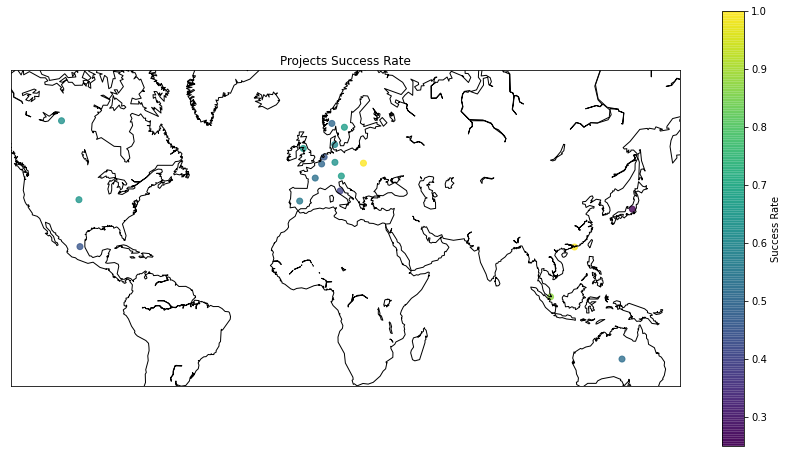

In [31]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

plt.figure(figsize = (15, 8))

m = Basemap(projection='merc',llcrnrlat=-35,urcrnrlat=70,llcrnrlon=-130,urcrnrlon=160,resolution='c')
m.drawcoastlines()

x, y = m(group_location_country.lon.tolist(), group_location_country.lat.tolist())

plt.scatter(x,y, label= None, c= group_location_country['success_rate'], 
            cmap='viridis', alpha=0.8)
plt.colorbar(label = 'Success Rate')

# for projects in [1, 100, 650]:
#     plt.scatter([], [], c='k', alpha=0.1, s=projects,
#                 label=str(projects))
    
# plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='total projects', loc = 'lower left')

plt.title('Projects Success Rate')

plt.show()

In general, the success rate across countries are evenly distributed (~60%). <br> 
Highest success rates (100%) are LU and HK, but this could be skewed due to smaller sample size (1 project and 6 projects respectively).

## Time Series

In [21]:
# Get month/year of launch/deadline
df['month_launched'] = pd.DatetimeIndex(df['launched_at']).month.astype(int)
df['year_launched'] = pd.DatetimeIndex(df['launched_at']).year.astype(int)
num_cols.append('month_launched')
num_cols.append('year_launched')

df_month_total = df.groupby(['month_launched'])['id'].count().reset_index().rename(columns={'id':'Total Projects'})
df_year_total = df.groupby(['year_launched'])['id'].count().reset_index().rename(columns={'id':'Total Projects'})

df_month = df.groupby(['month_launched', 'state'])['id'].count().reset_index().rename(columns={'id':'Count of Projects'})
df_year = df.groupby(['year_launched', 'state'])['id'].count().reset_index().rename(columns={'id':'Count of Projects'})

df_month = pd.merge(df_month, df_month_total, on = ['month_launched'])
df_year = pd.merge(df_year, df_year_total, on = ['year_launched'])

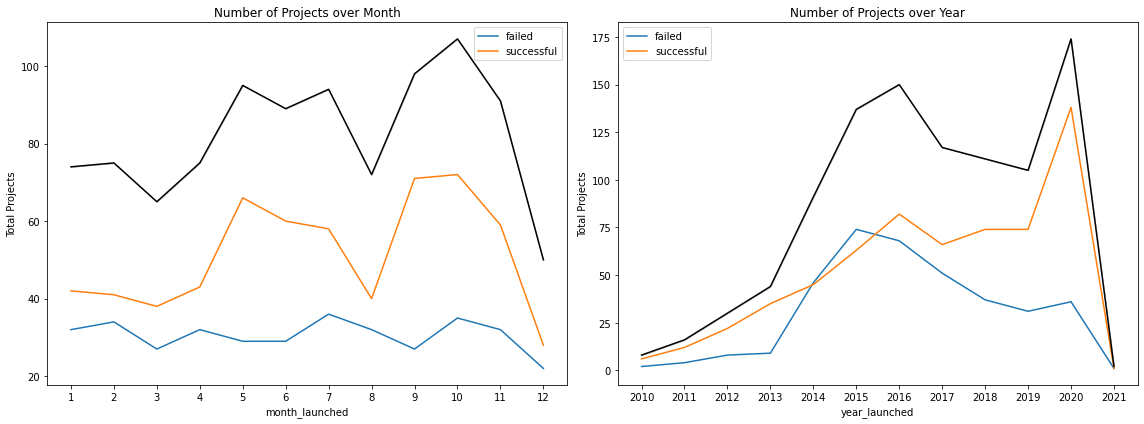

In [32]:
# Number of Projects launched over Time (month/ year)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

sns.lineplot('month_launched', 'Count of Projects', hue= 'state', data = df_month, ax=ax1)
sns.lineplot('month_launched', 'Total Projects', color= 'black', data = df_month, ax=ax1)
ax1.set_title('Number of Projects over Month')
ax1.legend(['failed', 'successful'])
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

sns.lineplot('year_launched', 'Count of Projects', hue= 'state', data = df_year, ax=ax2)
sns.lineplot('year_launched', 'Total Projects', color= 'black', data = df_year, ax=ax2)
ax2.set_title('Number of Projects over Year')
ax2.legend(['failed', 'successful'])
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.tight_layout()
plt.show()

<b> By Month: </b><br>
Month 10 has the highest activity (ie. most projects launched) while month 12 has the least. <br>
There's a spike in projects success every quarter (months 2,4,7,10). <br>
Projects have highest fail vs success rate on months 5 and 9.


<b> By Year: </b><br>
There is an evident increase in the total number of projects over the years (excl small sample size from 2021). <br>
2015 is the worst performing year, with almost 1:1 success to failed projects ratio. <br>
The success rate of projects have been increasing since 2015.
